In [ ]:
#드라이브 연결
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
#데이터프레임 다운
import pandas as pd
df = pd.read_csv('/content/MyDrive/MyDrive/csv_file/title_data2.csv',encoding='utf-8')
df_ml = pd.read_csv('/content/MyDrive/MyDrive/csv_file/ml_new_data1.csv',encoding = 'utf-8',index_col=0)

In [ ]:
df1 = df.loc[:,['제품명','제품코드','태그','총구매수']]

In [ ]:
#형태소 분석기 다운
#한국 맞춤법 교정 다운
!pip install konlpy
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 43.8 MB/s eta 0:00:00


In [ ]:
#한글 시각화 다운
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
#
from pykospacing import Spacing
from tqdm import tqdm

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from konlpy.tag import Okt
import re
from pykospacing import Spacing
from tqdm import tqdm
from collections import Counter

#대체 텍스트 설정
def text_preprocessor(s):
    s = s.strip()
    s = s.replace('셔츠', '')
    s = s.replace('오버사이즈','오버핏')
    s = s.replace('오버','오버핏')
    s = s.replace('오버핏핏','오버핏')
    s = s.replace('팔','')
    s = s.replace('긴','긴팔')
    s = s.replace('반','반팔')
    s = s.replace('보이','')
    s = s.replace('시티','시티보이')
    s = s.replace('컬렉션','')
    s = s.replace('반팔바지','반바지')
    s = s.replace('반바지','')
    s = s.replace('남방','')
    s = s.replace('시드','워시드')
    s = s.replace('워워시드','워시드')
    s = s.replace('베이직','베이식')
    return s

# 사용할 데이터 프레임 지정
df2 = df1.iloc[:, :]

# 형태소 분석기 초기화
# okt = Okt()

# 불용어 리스트 정의
stopwords = ['선택','셔츠','남방','팔','컬렉션','라이크','수','설빅','비쉬','후드자켓'
]

# '태그'와 '제품명' 열 전처리
df2['태그1'] = df2['태그'].apply(lambda x: re.sub(r'[^가-힣\s]', ' ', x))
df2['제품명1'] = df2['제품명'].apply(lambda x: re.sub(r'[^가-힣\s]', ' ', x))

# '제품명'과 '태그' 결합
df2['combined_text'] = df2['제품명1'] + ' ' + df2['태그1']
df2['clean_text'] = df2['combined_text'].str.replace('+', ' ')  # 불필요한 공백 제거

# 띄어쓰기 교정
spacing = Spacing()
s_data = [spacing(text) for text in tqdm(df2['clean_text'])]

# 토큰화 및 전처리
s_p_data = []
df2['nouns'] = ''
df2['pos_nouns'] = ''

# 불용어 및 대체 데이터 할당
for idx, text in enumerate(s_data):
    words = list(set(text.split()))
    processed_words = [text_preprocessor(word) for word in words if word not in stopwords]
    processed_text = ' '.join(processed_words)
    s_p_data.append(processed_text.strip())
    df2.at[idx, 'nouns'] = words
    df2.at[idx, 'pos_nouns'] = processed_text.strip()

# TF-IDF 벡터화를 위한 텍스트 변환
df2['nouns_idf'] = df2['pos_nouns'].apply(lambda tokens: ''.join(tokens))

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df2['nouns_idf'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# 상위 TF-IDF 단어 추출 함수
def get_top_tfidf_words(row, features, top_n=3):
    sorted_indices = row.argsort()[-top_n:][::-1]
    top_words = [(features[i], row[i]) for i in sorted_indices]
    return top_words

# 각 제품명에 대해 상위 빈도 단어와 상위 TF-IDF 단어를 추출하여 데이터프레임에 추가
top_frequency_words = []
top_tfidf_words = []
top_tfidf_scores = []

for idx, row in df2.iterrows():
    # 단어 빈도수 계산
    word_counts = Counter(row['pos_nouns'].split())
    common_words = word_counts.most_common(3)
    top_frequency_words.append(' '.join([word for word, _ in common_words]))

    # 상위 TF-IDF 단어 추출
    tfidf_top_words = get_top_tfidf_words(tfidf_matrix[idx].toarray().flatten(), vectorizer.get_feature_names_out())
    top_tfidf_words.append(' '.join([word for word, _ in tfidf_top_words]))
    top_tfidf_scores.append(sum(score for _, score in tfidf_top_words))

df2['top_frequency_words'] = top_frequency_words
df2['top_tfidf_words'] = top_tfidf_words

# 빈도수 데이터프레임 생성 및 정렬
all_words = ' '.join(df2['pos_nouns']).split()
word_counts = Counter(all_words)
frequency_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# TF-IDF 점수 데이터프레임 생성 및 정렬
tfidf_scores = tfidf_df.sum().sort_values(ascending=False)
tfidf_score_df = pd.DataFrame(tfidf_scores, columns=['TF-IDF Score']).reset_index()
tfidf_score_df.rename(columns={'index': 'Word'}, inplace=True)

# 총구매수 정규화
scaler = MinMaxScaler()
df2['normalized_sales'] = scaler.fit_transform(df2[['총구매수']])

# 제품명 벡터와 정규화된 총구매수를 결합하여 최종 점수를 계산
df2['name_score'] = df2['normalized_sales'] * top_tfidf_scores

# TF-IDF 스코어와 총구매수 고려한 스코어를 데이터프레임에 추가
df2['tfidf_score'] = top_tfidf_scores
df2['tfidf_score'] = scaler.fit_transform(df2[['tfidf_score']])
df2['total_score'] = df2['tfidf_score'] * df2['normalized_sales']


# 결과 출력
print(df2[['제품명', '제품코드', '총구매수', 'top_frequency_words', 'top_tfidf_words']])
print("\n전체 단어 빈도수 데이터프레임:\n", frequency_df.head(20))
print("\n전체 TF-IDF 점수 데이터프레임:\n", tfidf_score_df.head(20))


100%|██████████| 3796/3796 [07:02<00:00,  8.99it/s]


                                    제품명     제품코드     총구매수 top_frequency_words  \
0     [무료반품] 옵티멀 베이직 셔츠-화이트[린넨＆옥스포드 선택]   994588  26174.0       올드머니룩 옵티멀 반팔품   
1                      베이식 드레스 셔츠 [화이트]   983339  16346.0           와이 배송 베이식   
2                   릴렉스 핏 옥스포드 셔츠 [화이트]   854337  16459.0          특가 배송 아이코닉   
3               [세트][선택] 스톤 워싱 데님 셋업 블루  2524570  10687.0            데님 와이드 룩   
4         LAUNDRY SHIRT (LAVENDER GRAY)  2375962  10954.0          런드리 긴팔 오버핏   
...                                 ...      ...      ...                 ...   
3791    FLUFF CROCHET KNIT SHIRT - PINK  3462730     24.0           긴팔 웨어 캐주얼   
3792                    포플린 오리진핏 셔츠 화이트  3447587     25.0         포플린 오리진 화이트   
3793                  우먼 오버사이즈드핏 셔츠 화이트  3447574     22.0        오버핏드 화이트 노윤서   
3794    슬럽 조직 오픈칼라 셔츠  네이비 (423764LY1R)  3424255     25.0            조직 슬럽 오픈   
3795    코튼 베이직 반소매 셔츠  화이트 (323765HY11)  3397135     23.0         코튼 화이트 반팔소매   

       top_tfidf_words  
0 

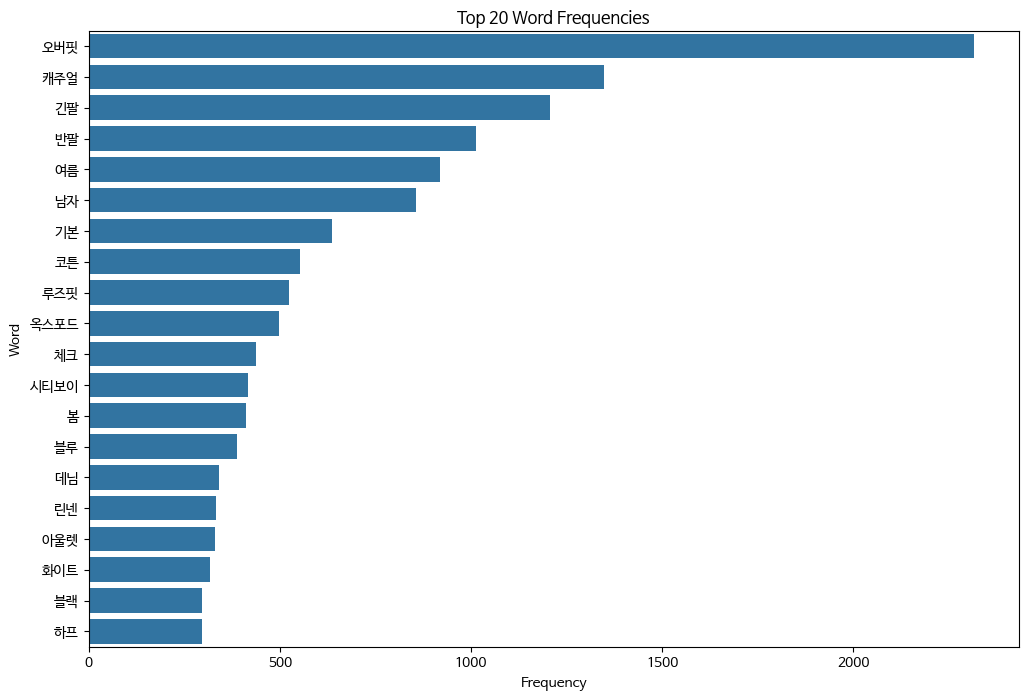

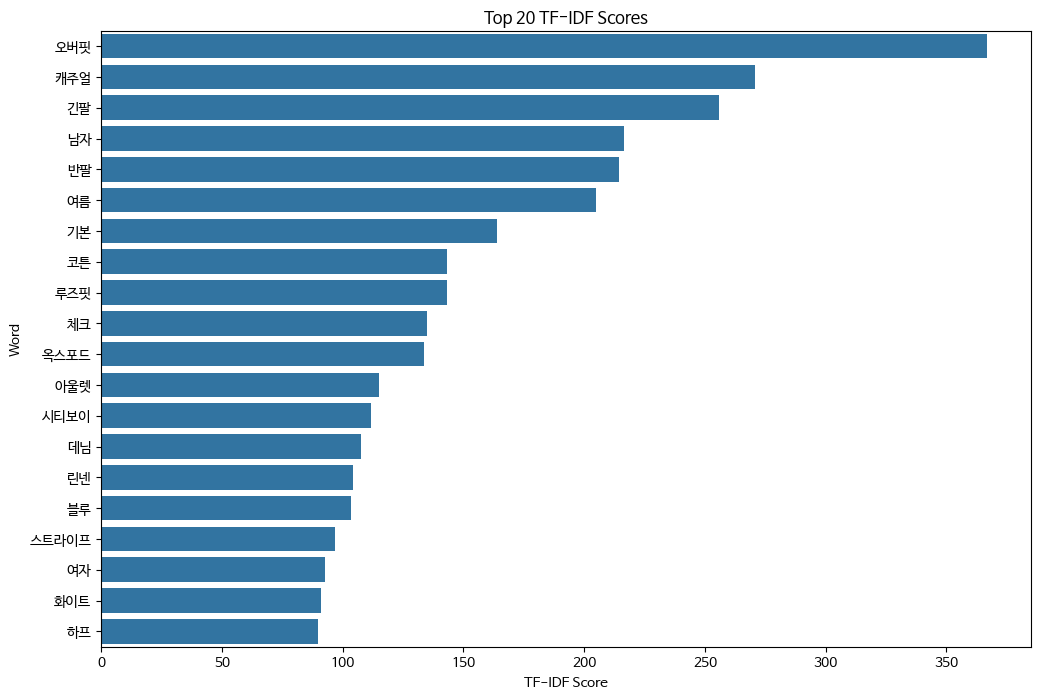

In [ ]:
# 빈도수와 tf-idf 순위 시각화
def plot_word_frequencies(df, column, title, xlabel, ylabel, n=20):
    plt.figure(figsize=(12, 8))
    sns.barplot(x=column, y='Word', data=df.head(n))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# 상위 20개 단어 빈도수 시각화
plot_word_frequencies(frequency_df, 'Frequency', 'Top 20 Word Frequencies', 'Frequency', 'Word')

# 상위 20개 TF-IDF 점수 시각화
plot_word_frequencies(tfidf_score_df, 'TF-IDF Score', 'Top 20 TF-IDF Scores', 'TF-IDF Score', 'Word')

In [ ]:
#워드클라우드를 위한 한글 데이터 위치 확인
import matplotlib.font_manager as fm
sys_font = fm.findSystemFonts()
[f for f in sys_font if 'Nanum' in f]

['/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf']

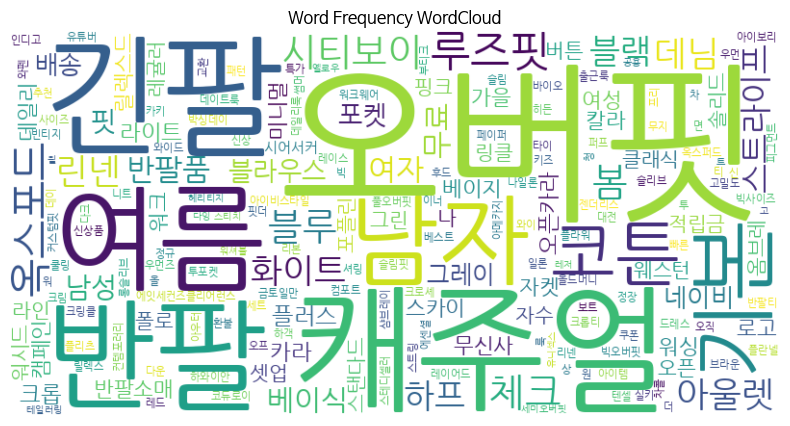

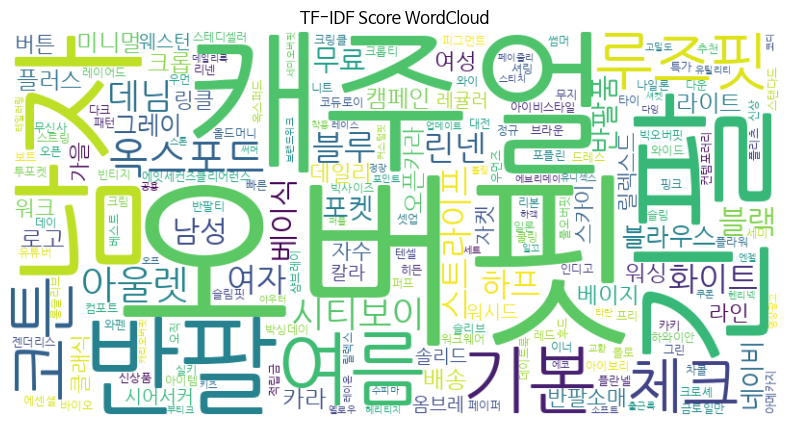

In [ ]:
from wordcloud import WordCloud
# # 빈도수와 tf-idf 순위 시각화 워드 클라우드
def plot_wordcloud(data, title):
    wordcloud = WordCloud(
        font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # 한글 폰트 경로 설정
        width=800,
        height=400,
        background_color='white'
    )
    plt.rc('font', family='NanumBarunGothic')
    plt.show()
    wordcloud.generate_from_frequencies(data)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# 빈도수 워드클라우드 시각화
frequency_dict = dict(frequency_df.values)
plot_wordcloud(frequency_dict, 'Word Frequency WordCloud')

# TF-IDF 점수 워드클라우드 시각화
tfidf_dict = dict(tfidf_score_df.values)
plot_wordcloud(tfidf_dict, 'TF-IDF Score WordCloud')